In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import networkx as nx
from sklearn.manifold import MDS
import matplotlib.animation as animation

## Loading all of the problems

In [2]:
DM_TEST_PROBLEM = np.load('lab2/test_problem.npy')

DM_G10 = np.load('lab2/problem_g_10.npy')
DM_G20 = np.load('lab2/problem_g_20.npy')
DM_G50 = np.load('lab2/problem_g_50.npy')
DM_G100 = np.load('lab2/problem_g_100.npy')
DM_G200 = np.load('lab2/problem_g_200.npy')
DM_G500 = np.load('lab2/problem_g_500.npy')
DM_G1000 = np.load('lab2/problem_g_1000.npy')

DM_R1_10 = np.load('lab2/problem_r1_10.npy')
DM_R1_20 = np.load('lab2/problem_r1_20.npy')
DM_R1_50 = np.load('lab2/problem_r1_50.npy')
DM_R1_100 = np.load('lab2/problem_r1_100.npy')
DM_R1_200 = np.load('lab2/problem_r1_200.npy')
DM_R1_500 = np.load('lab2/problem_r1_500.npy')
DM_R1_1000 = np.load('lab2/problem_r1_1000.npy')

DM_R2_10 = np.load('lab2/problem_r2_10.npy')
DM_R2_20 = np.load('lab2/problem_r2_20.npy')
DM_R2_50 = np.load('lab2/problem_r2_50.npy')
DM_R2_100 = np.load('lab2/problem_r2_100.npy')
DM_R2_200 = np.load('lab2/problem_r2_200.npy')
DM_R2_500 = np.load('lab2/problem_r2_500.npy')
DM_R2_1000 = np.load('lab2/problem_r2_1000.npy')

In [3]:
## Useful functions

In [4]:
def totalDistance(path, n_cities, distance_matrix):
    total_distance = 0
    for i in range(n_cities):
        total_distance += distance_matrix[path[i], path[(i + 1) % n_cities]]
    return total_distance

# Works with swap2opt
# Only works when distance_matrix is symmetric
# See file tsp.ipynb for detailed explanation
def fastDistance(path, n_cities, distance_matrix, current_distance, i, j):
    if i == j:
        return current_distance
    
    # Ensure i < j for consistent indexing
    if i > j:
        i, j = j, i
    
    # Handle edge case where segment is too small (no reversal happens)
    if j - i < 2:
        return current_distance
    
    city_at_i = path[i]
    city_at_i_plus_1 = path[i + 1]
    city_at_j_minus_1 = path[j - 1]
    city_at_j = path[j % n_cities]
    
    new_distance = current_distance
    new_distance -= distance_matrix[city_at_i][city_at_i_plus_1]
    new_distance -= distance_matrix[city_at_j_minus_1][city_at_j]
    new_distance += distance_matrix[city_at_i][city_at_j_minus_1]
    new_distance += distance_matrix[city_at_i_plus_1][city_at_j]    
    return new_distance

def generateRandomSolutionArray(num_cities):
    solution = list(range(num_cities))
    np.random.shuffle(solution)
    return solution

def generateGreedySolutionArray(distance_matrix, n_cities, start_city=0):
    unvisited = set(range(n_cities))
    current_city = start_city
    path = [current_city]
    unvisited.remove(current_city)
    while unvisited:
        list_available_cities_distances = [(distance_matrix[current_city][city], city) for city in unvisited]
        next_city = min(list_available_cities_distances, key=lambda x: x[0])[1]
        path.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city
    return path

def generateUltraGreedySolutionArray(distance_matrix, n_cities):
    path_len = float('inf')
    best_path = None
    for i in range(n_cities):
        path = generateGreedySolutionArray(distance_matrix, n_cities, start_city=i)
        current_path_len = totalDistance(path, n_cities, distance_matrix)
        if current_path_len < path_len:
            path_len = current_path_len
            best_path = path
    return best_path

## Plotting code

Explanations and sources for how the dimension reduction works can be found in the other jupyter notebooks.

In [5]:
def distanceMatrixToCoordinates(D):
    n = D.shape[0]    # distance_matrix is n x n

    M = np.zeros_like(D)
    for i in range(n):
        for j in range(n):
            M[i, j] = 0.5 * (D[0, j]**2 + D[i, 0]**2 - D[i, j]**2)
    # Matrix decomposition
    eigenvalues, eigenvectors = np.linalg.eig(M)
    assert np.allclose(eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T, M)

    X = eigenvectors @ np.diag(np.sqrt(np.abs(eigenvalues)))
    
    # Indices where eigenvalues are too small (considered as zero or negative)
    small_eigenvalue_indices = np.where(np.abs(eigenvalues) < 1e-10)[0]
    X = np.delete(X, small_eigenvalue_indices, axis=1)
    
    return X

# Only works when the distance matrix is symmetric
def reduceDimensionality(coordinates, target_dim=2):
    mds = MDS(n_components=target_dim, dissimilarity='euclidean', random_state=42)
    reduced_coordinates = mds.fit_transform(coordinates)
    return reduced_coordinates

def plotCities2D(coordinates_2D, city_names = None, title = ""):
    plt.figure(figsize=(6, 4))
    plt.scatter(coordinates_2D[:, 0], coordinates_2D[:, 1], color='blue')
    
    num_cities = coordinates_2D.shape[0]
    
    if city_names is not None:
        assert len(city_names) == num_cities, "Number of city names must match number of cities."
        for i, city in enumerate(city_names):
            plt.text(coordinates_2D[i, 0], coordinates_2D[i, 1], city, fontsize=9, ha='right')
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
def plotPath2D(coordinates_2D, path, city_names = None, title = ""):
    n = len(path)
    plotCities2D(coordinates_2D, city_names, title)
    for i in range(n):
        start_city = path[i]
        end_city = path[(i + 1) % n]
        plt.plot(
            [coordinates_2D[start_city, 0], coordinates_2D[end_city, 0]],
            [coordinates_2D[start_city, 1], coordinates_2D[end_city, 1]],
            color='blue'
        )
        
def reduceAndPlotPath(distance_matrix, path, city_names = None, title = ""):
    n = distance_matrix.shape[0]
    coordinates = distanceMatrixToCoordinates(distance_matrix)
    reduced_coordinates = reduceDimensionality(coordinates, target_dim=2)
    plotPath2D(reduced_coordinates, path, city_names, title)
    
def plotPathMatrix2D(coordinates_2D, path_matrix, city_names = None, title = ""):
    n = path_matrix.shape[0]
    plotCities2D(coordinates_2D, city_names, title)
    for i in range(n):
        for j in range(n):
            if path_matrix[i, j] == 1:
                plt.plot(
                    [coordinates_2D[i, 0], coordinates_2D[j, 0]],
                    [coordinates_2D[i, 1], coordinates_2D[j, 1]],
                    color='blue'
                )
def reduceAndPlotPathMatrix(distance_matrix, path_matrix, city_names = None, title = ""):
    n = distance_matrix.shape[0]
    coordinates = distanceMatrixToCoordinates(distance_matrix)
    reduced_coordinates = reduceDimensionality(coordinates, target_dim=2)
    plotPathMatrix2D(reduced_coordinates, path_matrix, city_names, title)
    
def plotEvolution(distance_evolution, title=""):
    plt.figure(figsize=(6, 4))
    plt.plot(distance_evolution, color='blue')
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Best Distance")
    plt.grid()

## Evolution algorithm

In [90]:
def generateInitialPopulation(n_cities, lmbda, force_greedy=False, d_matrix = None):
    population = np.zeros((lmbda, n_cities), dtype=int)
    
    if force_greedy:
        assert d_matrix is not None, "Distance matrix must be provided when force_greedy is True."
        greedy_individual = generateUltraGreedySolutionArray(d_matrix, n_cities)
        for i in range(lmbda):
            population[i] = greedy_individual.copy()
        return population

    for i in range(lmbda):
        individual = generateRandomSolutionArray(n_cities)
        population[i] = individual
    return population

def evaluatePopulation(population, distance_matrix, lmbda, n_cities):
    fitness_values = np.zeros(lmbda)
    for i in range(lmbda):
        fitness_values[i] = totalDistance(population[i], n_cities, distance_matrix)
    return fitness_values

def selectedParentsIndices(fitness_values, mu):
    selected = np.argsort(fitness_values)[:mu]
    return selected

def swap2opt(path, i, j, n_cities=None):
    new_solution = path.copy()
    new_solution[i+1:j] = path[i+1:j][::-1]
    return new_solution

def swapRandom(path, i, j, n_cities=None):
    new_solution = path.copy()
    new_solution[i], new_solution[j] = path[j], path[i]
    return new_solution

def createChildren(parents, n_cities, lmbda, mu, swap_function=swap2opt):
    n_children_per_parent = int(lmbda / mu)
    children = np.zeros((lmbda, n_cities), dtype=int)
    for i, parent in enumerate(parents):
        for j in range(n_children_per_parent):
            k, l = np.random.choice(n_cities, size=2, replace=False)
            # Ensure k < l for consistent behavior with swap2opt
            if k > l:
                k, l = l, k
            children[i * n_children_per_parent + j] = swap_function(parent.copy(), k, l, n_cities)
    
    # The best parent generates one child that is a duplicate of itself
    children[-1] = parents[0].copy()
    return children

def createChildrenFast(parents, parent_fitness, n_cities, lmbda, mu, distance_matrix, swap):
    n_children_per_parent = int(lmbda / mu)
    children = np.zeros((lmbda, n_cities), dtype=int)
    children_fitness = np.zeros(lmbda)
    
    for i, parent in enumerate(parents):
        parent_dist = parent_fitness[i]
        
        for j in range(n_children_per_parent):
            k, l = np.random.choice(n_cities, size=2, replace=False)
            # Ensure k < l for consistent behavior
            if k > l:
                k, l = l, k
            
            # Create child using swap2opt
            child = swap(parent.copy(), k, l, n_cities)
            child_idx = i * n_children_per_parent + j
            children[child_idx] = child
            
            # Calculate fitness using fast distance
            children_fitness[child_idx] = fastDistance(parent, n_cities, distance_matrix, parent_dist, k, l)
    
    # The best parent generates one child that is a duplicate of itself
    children[-1] = parents[0].copy()
    children_fitness[-1] = parent_fitness[0]
    
    return children, children_fitness

In [57]:
def simulatedAnnealing(distance_matrix,
                       initial_solution_array,
                       swap,
                       initial_temp=1000,
                       cooling_rate=0.999,
                       max_iterations=10000,
                       max_no_improve=100):
    
    n = distance_matrix.shape[0]
    current_solution = initial_solution_array.copy()
    current_distance = totalDistance(current_solution, n, distance_matrix)
    best_solution = current_solution.copy()
    best_distance = current_distance
    temp = initial_temp
    evolution_distance = []
    no_improvement_counter = 0

    for iteration in range(max_iterations):
        i, j = np.random.choice(n, 2, replace=False)
        
        # Ensure i < j for consistent behavior between swap2opt and fastDistance
        if i > j:
            i, j = j, i
        
        new_solution = swap(current_solution, i, j)
        # new_distance = totalDistance(new_solution, distance_matrix)
        new_distance = fastDistance(current_solution, n, distance_matrix, current_distance, i, j)
        # assert np.isclose(new_distance, new_distance2), f"Fast distance calculation error at iteration {iteration}: {new_distance} vs {new_distance2}"

        if new_distance < current_distance or np.random.rand() < np.exp(-(new_distance - current_distance) / temp):
            current_solution = new_solution
            current_distance = new_distance
            if current_distance < best_distance:
                best_solution = current_solution.copy()
                best_distance = current_distance
            else:
                no_improvement_counter += 1
                if no_improvement_counter >= max_no_improve:
                    print(f"No improvement for {max_no_improve} iterations. Stopping early at iteration {iteration}.")
                    return best_solution, best_distance, evolution_distance

            temp *= cooling_rate
         
        evolution_distance.append(current_distance)

    return best_solution, best_distance, evolution_distance

In [58]:
def evolutionAlgorithm(distance_matrix, lmbda, mu, num_generations=100, swap_function=swap2opt, max_no_improvement=20, force_greedy_start=False, use_fast_distance=True):
    n_cities = distance_matrix.shape[0]
    population = generateInitialPopulation(n_cities, lmbda, force_greedy=force_greedy_start, d_matrix=distance_matrix)

    best_fitness = float('inf')
    best_solution = None
    evolution_distance = []
    no_improvement_counter = 0
    
    # Check if we can use fast distance (only works with swap2opt on symmetric matrices)
    can_use_fast = use_fast_distance and (swap_function == swap2opt)
    
    # Initial evaluation
    fitness_values = evaluatePopulation(population, distance_matrix, lmbda, n_cities)
    
    for generation in range(num_generations):

        selected_indices = selectedParentsIndices(fitness_values, mu)

        current_fitness = np.min(fitness_values)
        evolution_distance.append(current_fitness)
        
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            # Keep a copy of the best solution found so far
            best_solution = population[selected_indices[0]].copy()
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= max_no_improvement:
                print(f"No improvement for {max_no_improvement} generations. Stopping early at generation {generation}.")
                return best_solution, best_fitness, evolution_distance
        
        parents = population[selected_indices]
        parent_fitness = fitness_values[selected_indices]
        
        # Create children with or without fast distance
        if can_use_fast:
            population, fitness_values = createChildrenFast(parents, parent_fitness, n_cities, lmbda, mu, distance_matrix, swapµ)
        else:
            population = createChildren(parents, n_cities, lmbda, mu, swap_function)
            fitness_values = evaluatePopulation(population, distance_matrix, lmbda, n_cities)
        
    # Final check after all generations
    if np.min(fitness_values) < best_fitness:
        best_solution = population[np.argmin(fitness_values)].copy()
        best_fitness = np.min(fitness_values)

    return best_solution, best_fitness, evolution_distance

No improvement for 50 generations. Stopping early at generation 96.


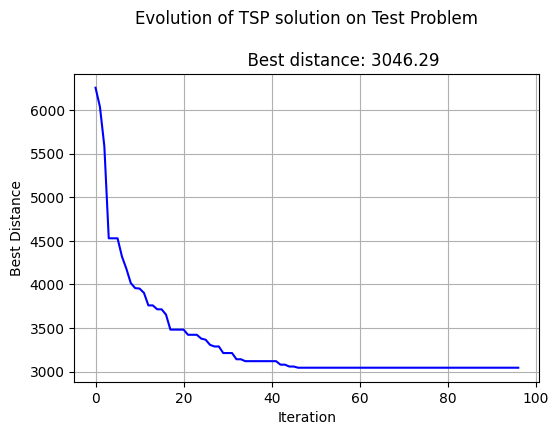

In [9]:
path_test_problem, dist_test_problem, evolution_test_problem = evolutionAlgorithm(DM_TEST_PROBLEM, lmbda=200, mu=50,
                                                                                  num_generations=200, swap_function=swap2opt,
                                                                                  max_no_improvement=50,
                                                                                  force_greedy_start=False)
plotEvolution(evolution_test_problem,
              title=f"""Evolution of TSP solution on Test Problem\n
              Best distance: {dist_test_problem:.2f}""")
# Best distance: 2823.79

## G Problems

No improvement for 50 generations. Stopping early at generation 57.


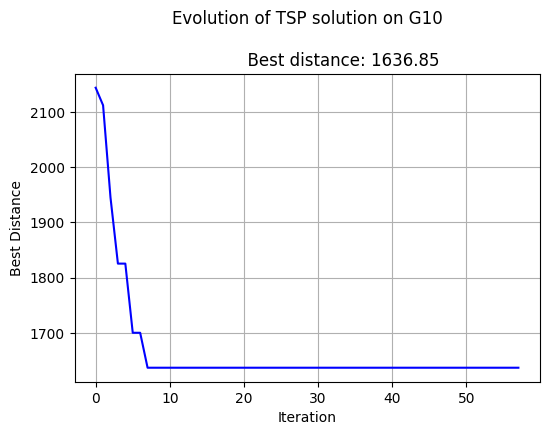

In [10]:
path_g10, dist_g10, evolution_g10 = evolutionAlgorithm(DM_G10, lmbda=200, mu=50,
                                                                      num_generations=200, swap_function=swap2opt,
                                                                      max_no_improvement=50,
                                                                      force_greedy_start=False)
plotEvolution(evolution_g10,
              title=f"""Evolution of TSP solution on G10\n
              Best distance: {dist_g10:.2f}""")
# Best distance found: 1497.66

No improvement for 50 generations. Stopping early at generation 82.


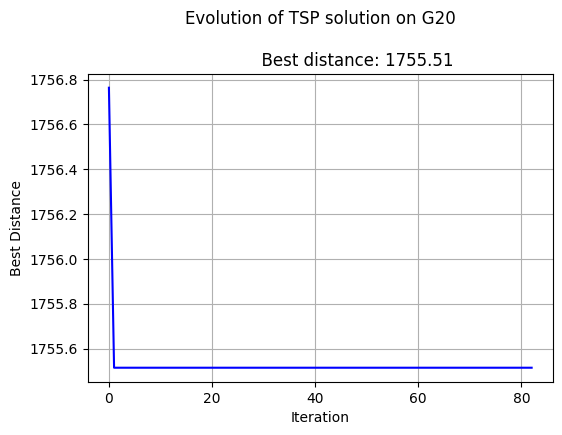

In [11]:
path_g20, dist_g20, evolution_g20 = evolutionAlgorithm(DM_G20, lmbda=200, mu=50,
                                                                      num_generations=200, swap_function=swap2opt,
                                                                      max_no_improvement=50,
                                                                      force_greedy_start=True)
plotEvolution(evolution_g20,
              title=f"""Evolution of TSP solution on G20\n
              Best distance: {dist_g20:.2f}""")
# Best distance found: 1755.51

No improvement for 100 generations. Stopping early at generation 424.


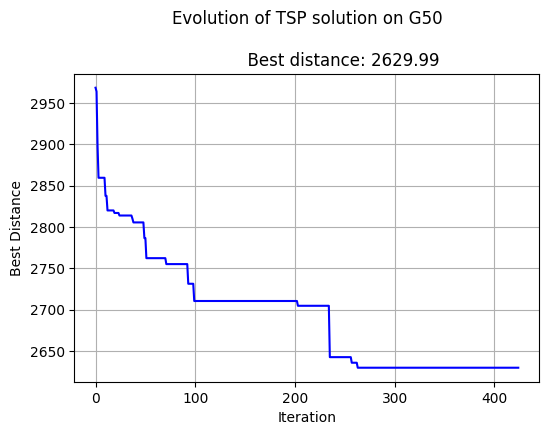

In [12]:
path_g50, dist_g50, evolution_g50 = evolutionAlgorithm(DM_G50, lmbda=200, mu=20,
                                                                      num_generations=1000, swap_function=swap2opt,
                                                                      max_no_improvement=100,
                                                                      force_greedy_start=True)
plotEvolution(evolution_g50,
              title=f"""Evolution of TSP solution on G50\n
              Best distance: {dist_g50:.2f}""")
# Best distance found: 2629.99

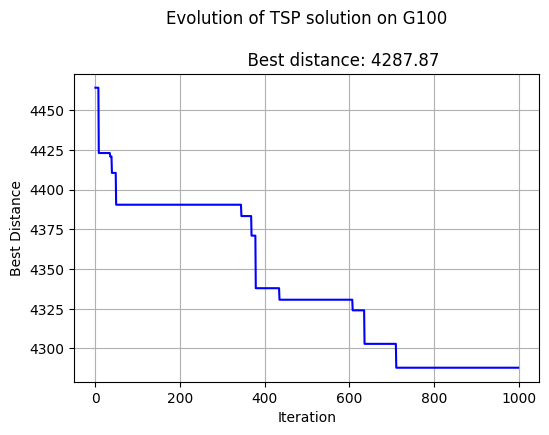

In [13]:
path_g100, dist_g100, evolution_g100 = evolutionAlgorithm(DM_G100, lmbda=200, mu=20,
                                                                        num_generations=1000, swap_function=swap2opt,
                                                                        max_no_improvement=300,
                                                                        force_greedy_start=True)
plotEvolution(evolution_g100,
              title=f"""Evolution of TSP solution on G100\n
              Best distance: {dist_g100:.2f}""")
# Best distance found: 4287.97

No improvement for 1000 generations. Stopping early at generation 4966.


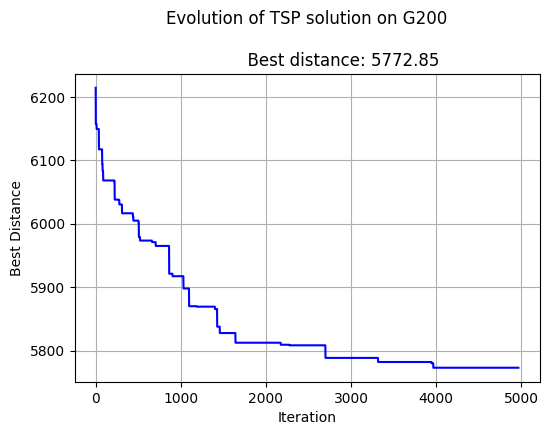

In [15]:
path_g200, dist_g200, evolution_g200 = evolutionAlgorithm(DM_G200, lmbda=200, mu=20,
                                                                        num_generations=5000, swap_function=swap2opt,
                                                                        max_no_improvement=1000,
                                                                        force_greedy_start=True)
plotEvolution(evolution_g200,
              title=f"""Evolution of TSP solution on G200\n
              Best distance: {dist_g200:.2f}""")
# Best distance found: 5688.67

In [ ]:
path_g500, dist_g500, evolution_g500 = evolutionAlgorithm(DM_G500, lmbda=200, mu=20,
                                                                        num_generations=10000, swap_function=swap2opt,
                                                                        max_no_improvement=1000,
                                                                        force_greedy_start=True)
plotEvolution(evolution_g500,
              title=f"""Evolution of TSP solution on G500\n
              Best distance: {dist_g500:.2f}""")
# Best distance found: 9352.00

KeyboardInterrupt: 

In [ ]:
path_g1000, dist_g1000, evolution_g1000 = evolutionAlgorithm(DM_G1000, lmbda=200, mu=20,
                                                                          num_generations=10000, swap_function=swap2opt,
                                                                          max_no_improvement=1000)
plotEvolution(evolution_g1000,
              title=f"""Evolution of TSP solution on G1000\n
              Best distance: {dist_g1000:.2f}""")

## R1 Problems

from now on the distance matrix aren't symetric anymore so we have to transform it in order to make it symetric but 2x larger

For exemple:

Nodes 0, 1, 2: entering cities 0, 1, 2

Nodes 3, 4, 5: leaving cities 0, 1, 2

A path in the original problem like 0 → 1 → 2 → 0 becomes in the doubled graph:
0 → 3 → 1 → 4 → 2 → 5 → 0

SO in the algorithm we have to separate when we enter in a city or exit a city

In [59]:
def makeMatrixSymetric(distance_matrix):
    n = distance_matrix.shape[0]
    new_matrix = np.full((2*n, 2*n), np.inf)
    for i in range(n):
        for j in range(n):
            if i != j:
                # From leaving city i (node i+n) to entering city j (node j)
                # Use the original distance from i to j
                new_matrix[i + n, j] = distance_matrix[i, j]
                # Make it symmetric: from leaving city j to entering city i
                new_matrix[j, i + n] = distance_matrix[i, j]
    
    # Infinite cost for staying in the same city because we want to move
    for i in range(n):
        new_matrix[i, i + n] = 0
        new_matrix[i + n, i] = 0
    
    return new_matrix

m = np.array([[1, 3, 5],
              [2, 3, 4],
              [4, 4, 5]])
print(makeMatrixSymetric(m))
print("\nMatrix shape:", makeMatrixSymetric(m).shape)
print("Is symmetric?", np.allclose(makeMatrixSymetric(m), makeMatrixSymetric(m).T))

[[inf inf inf  0.  2.  4.]
 [inf inf inf  3.  0.  4.]
 [inf inf inf  5.  4.  0.]
 [ 0.  3.  5. inf inf inf]
 [ 2.  0.  4. inf inf inf]
 [ 4.  4.  0. inf inf inf]]

Matrix shape: (6, 6)
Is symmetric? True


In [ ]:
def convertDoublePathToSimplePath(doubled_path, n_original_cities):
    city_order = []
    
    for i in range(len(doubled_path)):
        current = doubled_path[i]
        next_node = doubled_path[(i + 1) % len(doubled_path)]
        if current >= n_original_cities and next_node < n_original_cities:
            from_city = current - n_original_cities
            to_city = next_node
            
            if len(city_order) == 0:
                city_order.append(from_city)
            city_order.append(to_city)
    
    # Remove the last city if it's the same as the first (closing the cycle)
    if len(city_order) > 1 and city_order[-1] == city_order[0]:
        city_order = city_order[:-1]
    
    return city_order

def convertSimplePathToDoublePath(simple_path):
    doubled_path = []
    for node in simple_path:
        doubled_path.append(node)  # Enter the city (original node)
        doubled_path.append(node + len(simple_path))  # Leave the city (node + n)
    return doubled_path

In [ ]:
def swap2optNonS(path, i, j, n_cities):
    # Convert doubled path to simple path
    n_original = n_cities // 2
    path_s = convertDoublePathToSimplePath(path, n_original)
    
    # Pick two random indices for the simple path
    n_simple = len(path_s)
    i_simple, j_simple = np.random.choice(n_simple, size=2, replace=False)
    
    # Ensure i < j for swap2opt
    if i_simple > j_simple:
        i_simple, j_simple = j_simple, i_simple
    
    # Apply swap2opt on the simple path
    new_path_simple = swap2opt(path_s, i_simple, j_simple, n_simple)
    
    # Convert back to doubled path
    return np.array(convertSimplePathToDoublePath(list(new_path_simple)))

In [ ]:
def evolutionAlgorithmNonS(distance_matrix, lmbda, mu, num_generations=100, max_no_improvement=20, force_greedy_start=False):
    n_cities_original = distance_matrix.shape[0]
    
    # Generate initial population for the ORIGINAL cities
    population_simple = generateInitialPopulation(n_cities_original, lmbda, force_greedy=force_greedy_start, d_matrix=distance_matrix)

    # Create symmetric doubled matrix
    distance_matrix_doubled = makeMatrixSymetric(distance_matrix)
    n_cities_doubled = 2 * n_cities_original
    
    # Convert each path in the population to a doubled path
    population = np.zeros((lmbda, n_cities_doubled), dtype=int)
    for i in range(lmbda):
        population[i] = np.array(convertSimplePathToDoublePath(list(population_simple[i])))

    best_fitness = float('inf')
    best_solution = None
    evolution_distance = []
    no_improvement_counter = 0
    
    # Initial evaluation
    fitness_values = evaluatePopulation(population, distance_matrix_doubled, lmbda, n_cities_doubled)
    
    # Initialize best_solution with the best from initial population
    best_idx = np.argmin(fitness_values)
    best_solution = population[best_idx].copy()
    best_fitness = fitness_values[best_idx]
    
    for generation in range(num_generations):
        selected_indices = selectedParentsIndices(fitness_values, mu)

        current_fitness = np.min(fitness_values)
        evolution_distance.append(current_fitness)
        
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            # Keep a copy of the best solution found so far
            best_solution = population[selected_indices[0]].copy()
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= max_no_improvement:
                print(f"No improvement for {max_no_improvement} generations. Stopping early at generation {generation}.")
                return best_solution, best_fitness, evolution_distance
        
        parents = population[selected_indices]
        
        # Create children using regular evaluation (not fast distance, as matrix is not truly symmetric)
        population = createChildren(parents, n_cities_doubled, lmbda, mu, swap_function=swap2optNonS)
        fitness_values = evaluatePopulation(population, distance_matrix_doubled, lmbda, n_cities_doubled)

    # Final check after all generations
    if np.min(fitness_values) < best_fitness:
        best_solution = population[np.argmin(fitness_values)].copy()
        best_fitness = np.min(fitness_values)

    return best_solution, best_fitness, evolution_distance

No improvement for 50 generations. Stopping early at generation 55.


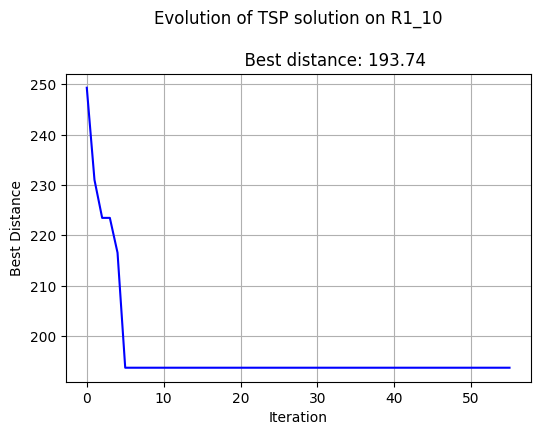

In [172]:
path_r1_10, dist_r1_10, evolution_r1_10 = evolutionAlgorithmNonS(DM_R1_10, lmbda=200, mu=50,
                                                                      num_generations=1000,
                                                                      max_no_improvement=50,
                                                                      force_greedy_start=False)

# Extract simple path and calculate actual distance on original matrix
simple_path_r1_10 = convertDoublePathToSimplePath(path_r1_10, DM_R1_10.shape[0])
actual_dist_r1_10 = totalDistance(simple_path_r1_10, DM_R1_10.shape[0], DM_R1_10)

plotEvolution(evolution_r1_10,
              title=f"""Evolution of TSP solution on R1_10\n
              Best distance: {actual_dist_r1_10:.2f}""")
# Best distance found: 184.27

No improvement for 100 generations. Stopping early at generation 125.


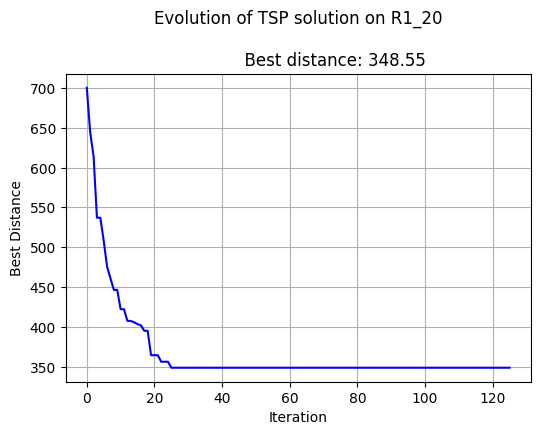

In [184]:
path_r1_20, dist_r1_20, evolution_r1_20 = evolutionAlgorithmNonS(DM_R1_20, lmbda=500, mu=50,
                                                                      num_generations=200,
                                                                      max_no_improvement=100,
                                                                      force_greedy_start=False)

# Extract simple path and calculate actual distance on original matrix
simple_path_r1_20 = convertDoublePathToSimplePath(path_r1_20, DM_R1_20.shape[0])
actual_dist_r1_20 = totalDistance(simple_path_r1_20, DM_R1_20.shape[0], DM_R1_20)

plotEvolution(evolution_r1_20,
              title=f"""Evolution of TSP solution on R1_20\n
              Best distance: {actual_dist_r1_20:.2f}""")
# Best distance found: 340.21

No improvement for 200 generations. Stopping early at generation 676.


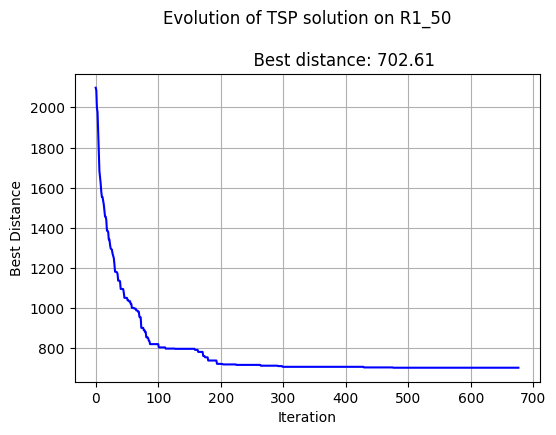

In [185]:
path_r1_50, dist_r1_50, evolution_r1_50 = evolutionAlgorithmNonS(DM_R1_50, lmbda=200, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=False)

# Extract simple path and calculate actual distance on original matrix
simple_path_r1_50 = convertDoublePathToSimplePath(path_r1_50, DM_R1_50.shape[0])
actual_dist_r1_50 = totalDistance(simple_path_r1_50, DM_R1_50.shape[0], DM_R1_50)

plotEvolution(evolution_r1_50,
              title=f"""Evolution of TSP solution on R1_50\n
              Best distance: {actual_dist_r1_50:.2f}""")
# Best distance found: 596.59

No improvement for 200 generations. Stopping early at generation 305.


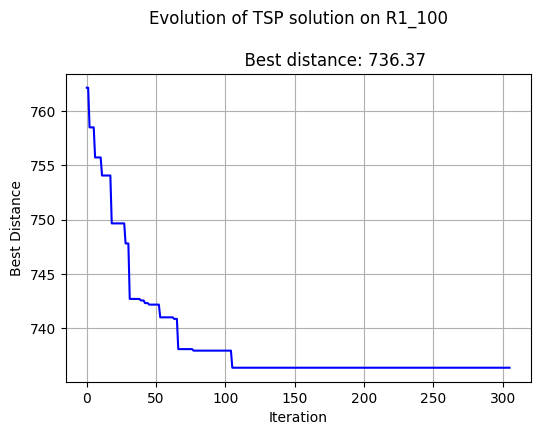

In [ ]:
path_r1_100, dist_r1_100, evolution_r1_100 = evolutionAlgorithmNonS(DM_R1_100, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r1_100 = convertDoublePathToSimplePath(path_r1_100, DM_R1_100.shape[0])
actual_dist_r1_100 = totalDistance(simple_path_r1_100, DM_R1_100.shape[0], DM_R1_100)

plotEvolution(evolution_r1_100,
              title=f"""Evolution of TSP solution on R1_100\n
              Best distance: {actual_dist_r1_100:.2f}""")
# Best distance found: 736.37

No improvement for 200 generations. Stopping early at generation 614.


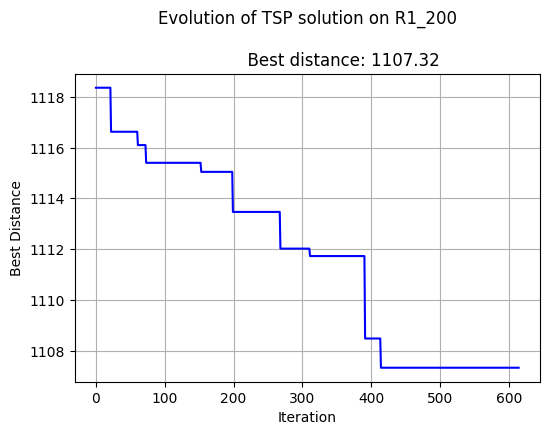

In [198]:
path_r1_200, dist_r1_200, evolution_r1_200 = evolutionAlgorithmNonS(DM_R1_200, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r1_200 = convertDoublePathToSimplePath(path_r1_200, DM_R1_200.shape[0])
actual_dist_r1_200 = totalDistance(simple_path_r1_200, DM_R1_200.shape[0], DM_R1_200)

plotEvolution(evolution_r1_200,
              title=f"""Evolution of TSP solution on R1_200\n
              Best distance: {actual_dist_r1_200:.2f}""")
# Best distance found: 1103.90

No improvement for 200 generations. Stopping early at generation 399.


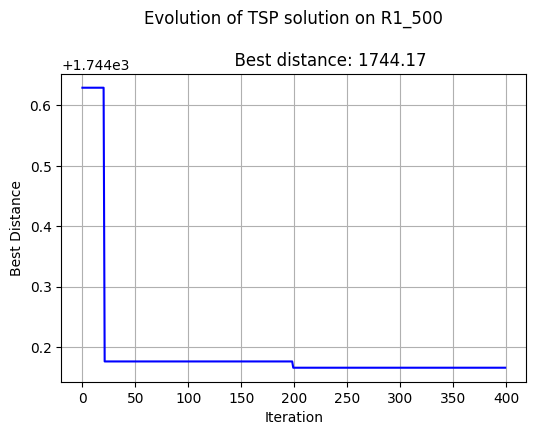

In [ ]:
path_r1_500, dist_r1_500, evolution_r1_500 = evolutionAlgorithmNonS(DM_R1_500, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r1_500 = convertDoublePathToSimplePath(path_r1_500, DM_R1_500.shape[0])
actual_dist_r1_500 = totalDistance(simple_path_r1_500, DM_R1_500.shape[0], DM_R1_500)

plotEvolution(evolution_r1_500,
              title=f"""Evolution of TSP solution on R1_500\n
              Best distance: {actual_dist_r1_500:.2f}""")
# Best distance found: 1744.17

No improvement for 200 generations. Stopping early at generation 373.


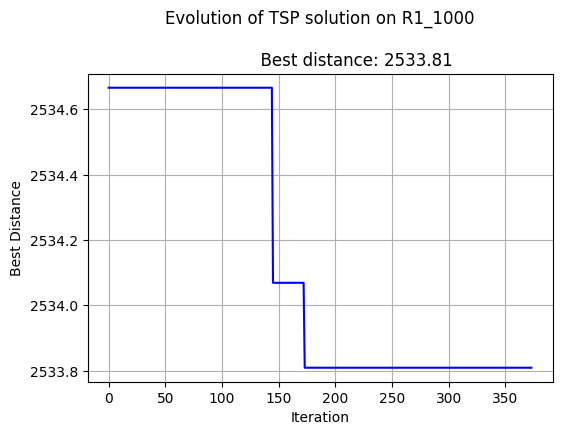

In [ ]:
path_r1_1000, dist_r1_1000, evolution_r1_1000 = evolutionAlgorithmNonS(DM_R1_1000, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r1_1000 = convertDoublePathToSimplePath(path_r1_1000, DM_R1_1000.shape[0])
actual_dist_r1_1000 = totalDistance(simple_path_r1_1000, DM_R1_1000.shape[0], DM_R1_1000)

plotEvolution(evolution_r1_1000,
              title=f"""Evolution of TSP solution on R1_1000\n
              Best distance: {actual_dist_r1_1000:.2f}""")
# Best distance found: 2533.81

## Problem R2

If the curve is completely flat it means that the algorithm is not able to improve the initial solution (usually greedy)

It's like the algorithm doesn't even need to run if it turns out that it is the optimal solution (it was not the optimal solution for g and r1 problems)

No improvement for 200 generations. Stopping early at generation 199.


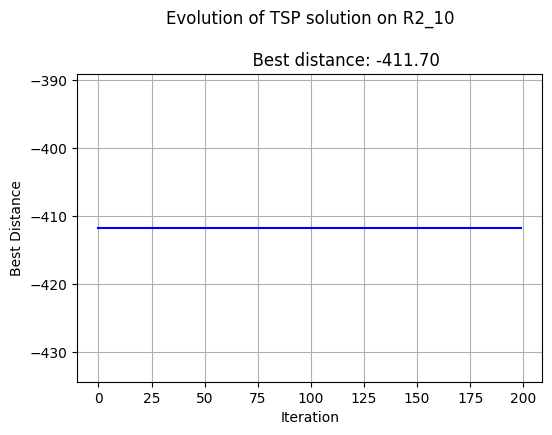

In [ ]:
path_r2_10, dist_r2_10, evolution_r2_10 = evolutionAlgorithmNonS(DM_R2_10, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r2_10 = convertDoublePathToSimplePath(path_r2_10, DM_R2_10.shape[0])
actual_dist_r2_10 = totalDistance(simple_path_r2_10, DM_R2_10.shape[0], DM_R2_10)

plotEvolution(evolution_r2_10,
              title=f"""Evolution of TSP solution on R2_10\n
              Best distance: {actual_dist_r2_10:.2f}""")
# Best distance found: -411.70

No improvement for 200 generations. Stopping early at generation 199.


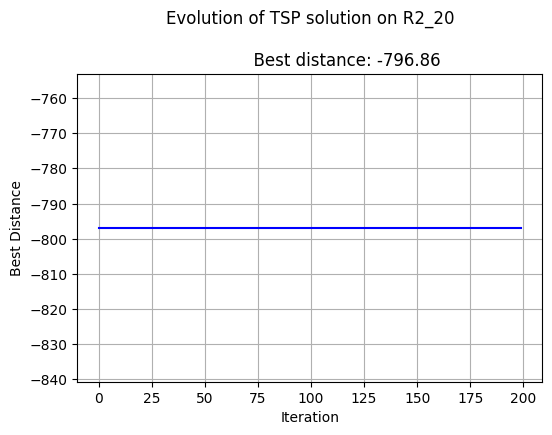

In [ ]:
path_r2_20, dist_r2_20, evolution_r2_20 = evolutionAlgorithmNonS(DM_R2_20, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r2_20 = convertDoublePathToSimplePath(path_r2_20, DM_R2_20.shape[0])
actual_dist_r2_20 = totalDistance(simple_path_r2_20, DM_R2_20.shape[0], DM_R2_20)

plotEvolution(evolution_r2_20,
              title=f"""Evolution of TSP solution on R2_20\n
              Best distance: {actual_dist_r2_20:.2f}""")
# Best distance found: -796.86

No improvement for 200 generations. Stopping early at generation 199.


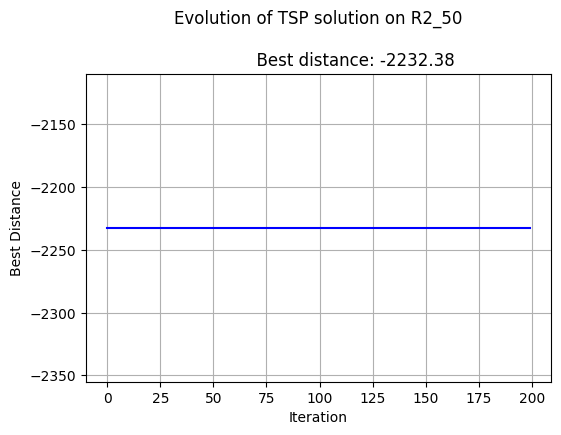

In [ ]:
path_r2_50, dist_r2_50, evolution_r2_50 = evolutionAlgorithmNonS(DM_R2_50, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r2_50 = convertDoublePathToSimplePath(path_r2_50, DM_R2_50.shape[0])
actual_dist_r2_50 = totalDistance(simple_path_r2_50, DM_R2_50.shape[0], DM_R2_50)

plotEvolution(evolution_r2_50,
              title=f"""Evolution of TSP solution on R2_50\n
              Best distance: {actual_dist_r2_50:.2f}""")
# Best distance found: -2232.38

No improvement for 200 generations. Stopping early at generation 199.


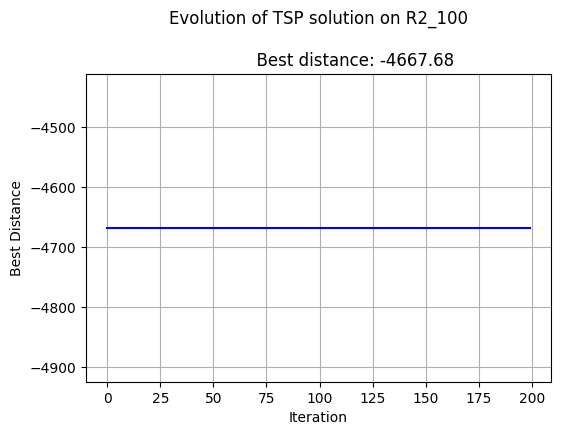

In [ ]:
path_r2_100, dist_r2_100, evolution_r2_100 = evolutionAlgorithmNonS(DM_R2_100, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r2_100 = convertDoublePathToSimplePath(path_r2_100, DM_R2_100.shape[0])
actual_dist_r2_100 = totalDistance(simple_path_r2_100, DM_R2_100.shape[0], DM_R2_100)

plotEvolution(evolution_r2_100,
              title=f"""Evolution of TSP solution on R2_100\n
              Best distance: {actual_dist_r2_100:.2f}""")
# Best distance found: -4667.68

No improvement for 200 generations. Stopping early at generation 199.


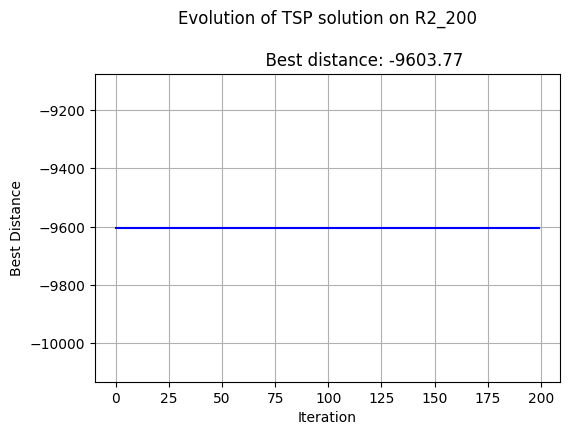

In [ ]:
path_r2_200, dist_r2_200, evolution_r2_200 = evolutionAlgorithmNonS(DM_R2_200, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r2_200 = convertDoublePathToSimplePath(path_r2_200, DM_R2_200.shape[0])
actual_dist_r2_200 = totalDistance(simple_path_r2_200, DM_R2_200.shape[0], DM_R2_200)

plotEvolution(evolution_r2_200,
              title=f"""Evolution of TSP solution on R2_200\n
              Best distance: {actual_dist_r2_200:.2f}""")
# Best distance found: -9603.77

No improvement for 200 generations. Stopping early at generation 199.


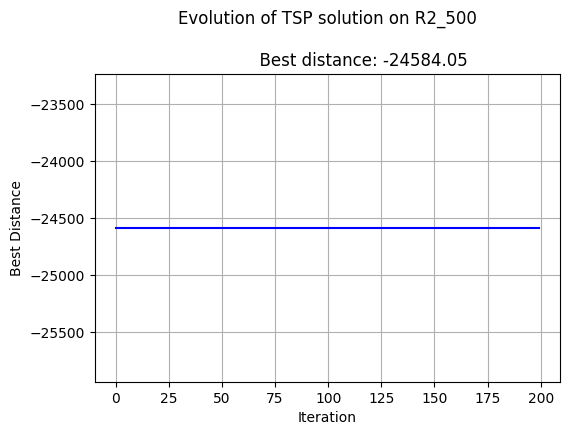

In [ ]:
path_r2_500, dist_r2_500, evolution_r2_500 = evolutionAlgorithmNonS(DM_R2_500, lmbda=500, mu=20,
                                                                      num_generations=1000,
                                                                      max_no_improvement=200,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r2_500 = convertDoublePathToSimplePath(path_r2_500, DM_R2_500.shape[0])
actual_dist_r2_500 = totalDistance(simple_path_r2_500, DM_R2_500.shape[0], DM_R2_500)

plotEvolution(evolution_r2_500,
              title=f"""Evolution of TSP solution on R2_500\n
              Best distance: {actual_dist_r2_500:.2f}""")
# Best distance found: -24584.05

No improvement for 1 generations. Stopping early at generation 0.


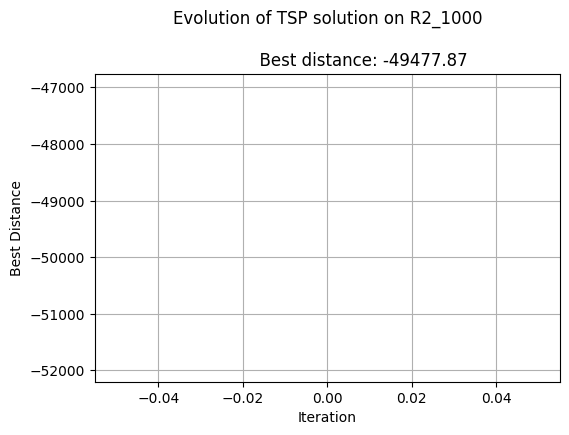

In [ ]:
# Let's try the worse parameters for R2_1000 to see if it still works (only ones)
path_r2_1000, dist_r2_1000, evolution_r2_1000 = evolutionAlgorithmNonS(DM_R2_1000, lmbda=1, mu=1,
                                                                      num_generations=1,
                                                                      max_no_improvement=1,
                                                                      force_greedy_start=True)

# Extract simple path and calculate actual distance on original matrix
simple_path_r2_1000 = convertDoublePathToSimplePath(path_r2_1000, DM_R2_1000.shape[0])
actual_dist_r2_1000 = totalDistance(simple_path_r2_1000, DM_R2_1000.shape[0], DM_R2_1000)

plotEvolution(evolution_r2_1000,
              title=f"""Evolution of TSP solution on R2_1000\n
              Best distance: {actual_dist_r2_1000:.2f}""")
# Best distance found: -49477.87

In [220]:
# let's try the r2 1000 without the algorithm, just the initial solution

simple_path_r2_1000_no_algo = generateUltraGreedySolutionArray(DM_R2_1000, DM_R2_1000.shape[0])
actual_dist_r2_1000_no_algo = totalDistance(simple_path_r2_1000_no_algo, DM_R2_1000.shape[0], DM_R2_1000)
ic(actual_dist_r2_1000_no_algo)

ic| actual_dist_r2_1000_no_algo: np.float64(-49477.871905388274)


np.float64(-49477.871905388274)

Ok I don't why but it seems that the ultra greedy initial path is the optimal solution for all of the R2 problems. I won't complain !